## Vertiport Location Optimization
### Data Analysis Capstone Design (SWCON)

#### Junyoung Lee & Tae Kyoung Lee
##### Prof. Myoung Ah Cho

#### Library

In [1]:
import geopandas as gpd
import folium
from IPython.display import display
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from folium import Choropleth
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from shapely.geometry import Polygon, box
from pyproj import CRS
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary
from shapely.geometry import Point

<Axes: >

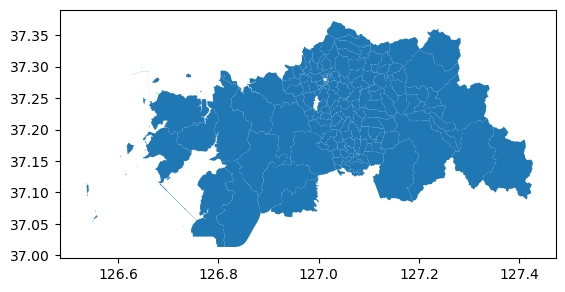

In [2]:
our_region = "/Users/taekyounglee/Documents/projects/DA_Capstone/data/our_region.shp"
gdf = gpd.read_file(our_region)

# # gdf.columns
# # gdf.info()
# # gdf.describe
gdf.plot()

In [3]:
gdf = gdf.to_crs(epsg=4326)

# 중심 좌표 설정
center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]

m = folium.Map(location=center, zoom_start=12)

# GeoDataFrame 데이터를 지도에 추가
for _, row in gdf.iterrows():
    # 폴리곤 경계를 추가
    folium.GeoJson(
        row.geometry,
        tooltip=f"EMD_CD: {row['EMD_CD']}"  # 마우스 오버 시 EMD_CD 표시
    ).add_to(m)

display(m)

/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/2676911147.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]


#### Scaling

In [4]:
df=pd.read_csv('/Users/taekyounglee/Documents/projects/DA_Capstone/data/all.csv',encoding='utf-8')

columns_to_normalize = ['total', 'transformation', 'city_income', 'starbucks']

# 쉼표를 제거하고 숫자로 변환
for col in columns_to_normalize:
    df[col] = df[col].replace({',': ''}, regex=True).astype(float)

scaler = MinMaxScaler()
df_minmax = scaler.fit_transform(df[columns_to_normalize])
df_minmax = pd.DataFrame(df_minmax, columns=[f'{col}_normalized' for col in columns_to_normalize])

# 원래 DataFrame에 정규화된 값 추가
df = pd.concat([df, df_minmax], axis=1)

# 정규화된 값의 합계를 계산하여 'sum' 열 추가
df['sum'] = df_minmax.sum(axis=1)

In [5]:
gdf['EMD_CD'] = gdf['EMD_CD'].astype(str)
df['EMD_CD'] = df['EMD_CD'].astype(str)
merged_gdf = gdf.merge(df, on='EMD_CD')

In [6]:
min_value = merged_gdf['sum'].min()
max_value = merged_gdf['sum'].max()

# Folium 맵 생성
center = [merged_gdf.geometry.centroid.y.mean(), merged_gdf.geometry.centroid.x.mean()]
m = folium.Map(location=center, zoom_start=12)

# 'sum' 값을 기준으로 색 명도 설정
# 여기서는 sum 값에 따라 색을 설정하는 예시 (만약 `sum` 값이 클수록 색이 밝아짐)
colormap = plt.cm.Reds  # 명도에 따라 색을 설정할 colormap

# GeoJSON 형식으로 각 구역의 속성 데이터를 folium에 추가
for _, row in merged_gdf.iterrows():
    # 'sum' 값을 색의 강도로 매핑
    color = colormap((row['sum'] - min_value) / (max_value - min_value))  # 0에서 1 사이로 정규화
    color_hex = mcolors.rgb2hex(color[:3])  # RGB 값을 HEX로 변환

    folium.GeoJson(
        row.geometry,
        tooltip=f"행정동코드: {row['EMD_CD']}, 가중합: {row['sum']}",  # 툴팁에 정보 표시
        style_function=lambda x, color=color_hex: {
            'fillColor': color,
            'color': 'black',  # 경계선 색
            'weight': 1,
            'fillOpacity': 0.7
        }
    ).add_to(m)

# Jupyter Notebook에서 지도 확인
m

/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/1063707842.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [merged_gdf.geometry.centroid.y.mean(), merged_gdf.geometry.centroid.x.mean()]


#### 격자 생성

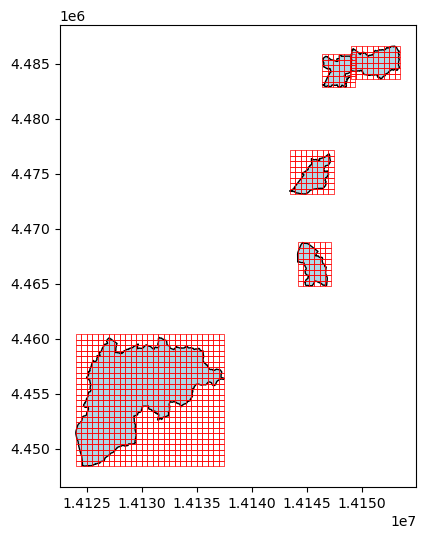

In [7]:
def create_grid(bounds, grid_size=500):
    """격자 범위와 크기를 받아 격자 생성"""
    minx, miny, maxx, maxy = bounds
    grid_cells = []

    # 500m 간격으로 X, Y 범위 생성
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)

    # 격자 셀을 생성
    for x in x_coords:
        for y in y_coords:
            # 각 셀을 사각형으로 만들기
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    return grid_cells

# Shapefile과 DataFrame 병합
gdf['EMD_CD'] = gdf['EMD_CD'].astype(str)
df['EMD_CD'] = df['EMD_CD'].astype(str)
merged_gdf = gdf.merge(df, on='EMD_CD')

# 'sum' 값이 2보다 큰 구역 필터링
filtered_gdf = merged_gdf[merged_gdf['sum'] > 2.5]

# 좌표계를 EPSG:3857로 변환 (미터 단위로 작업하기 위해)
filtered_gdf = filtered_gdf.to_crs(epsg=3857)

# 500m x 500m 격자 생성
grid_cells = []
for _, row in filtered_gdf.iterrows():
    # 각 구역의 경계를 가져와서 그리드로 나누기
    bounds = row.geometry.bounds
    grid_cells.extend(create_grid(bounds))

# 격자 데이터를 GeoDataFrame으로 변환
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=filtered_gdf.crs)

# 격자와 원본 데이터 시각화
fig, ax = plt.subplots(figsize=(6, 6))
filtered_gdf.plot(ax=ax, color='lightblue', edgecolor='black')
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

plt.show()

#### 격자의 위경도 좌표

/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/2987959922.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['centroid'] = grid_gdf.geometry.centroid


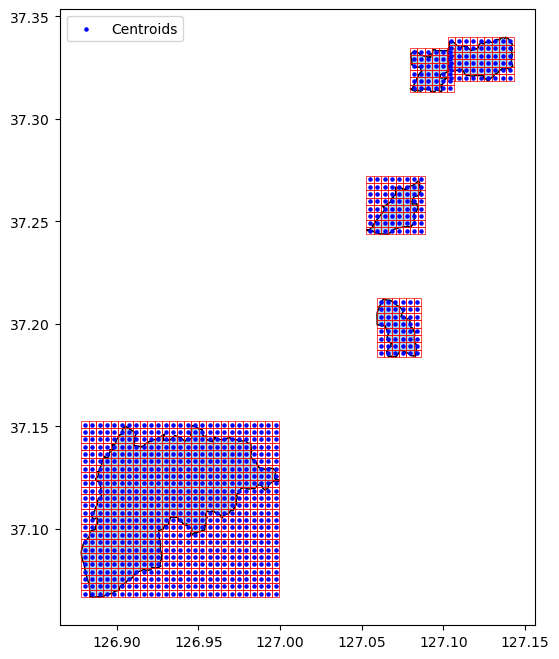

In [8]:
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=filtered_gdf.crs)
grid_gdf = grid_gdf.to_crs(epsg=4326)

# 격자의 중심 좌표 계산
grid_gdf['centroid'] = grid_gdf.geometry.centroid
grid_gdf['longitude'] = grid_gdf['centroid'].x  # 경도
grid_gdf['latitude'] = grid_gdf['centroid'].y  # 위도


# 격자와 원본 데이터 시각화 (위경도 기준)
fig, ax = plt.subplots(figsize=(8, 8))
filtered_gdf.to_crs(epsg=4326).plot(ax=ax, color='lightblue', edgecolor='black')
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

plt.scatter(grid_gdf['longitude'], grid_gdf['latitude'], color='blue', s=5, label='Centroids')
plt.legend()
plt.show()

In [9]:
grid_gdf['centroid'] = grid_gdf.geometry.centroid

# 중심 좌표를 위경도(EPSG:4326)로 변환
grid_gdf = grid_gdf.to_crs(epsg=4326)
grid_gdf['longitude'] = grid_gdf['centroid'].x  # 중심 경도
grid_gdf['latitude'] = grid_gdf['centroid'].y  # 중심 위도

# 격자의 중심 좌표를 데이터프레임 형태로 출력
grid_centroids = grid_gdf[['longitude', 'latitude']]

/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/3214837500.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['centroid'] = grid_gdf.geometry.centroid


In [10]:
grid_gdf

geometry  \
0    POLYGON ((127.05742 37.24369, 127.05742 37.247...   
1    POLYGON ((127.05742 37.24727, 127.05742 37.250...   
2    POLYGON ((127.05742 37.25084, 127.05742 37.254...   
3    POLYGON ((127.05742 37.25442, 127.05742 37.257...   
4    POLYGON ((127.05742 37.25799, 127.05742 37.261...   
..                                                 ...   
845  POLYGON ((126.9995 37.13476, 126.9995 37.13834...   
846  POLYGON ((126.9995 37.13834, 126.9995 37.14192...   
847  POLYGON ((126.9995 37.14192, 126.9995 37.1455,...   
848  POLYGON ((126.9995 37.1455, 126.9995 37.14908,...   
849  POLYGON ((126.9995 37.14908, 126.9995 37.15266...   

                       centroid   longitude   latitude  
0    POINT (127.05518 37.24548)  127.055175  37.245478  
1    POINT (127.05518 37.24905)  127.055175  37.249054  
2    POINT (127.05518 37.25263)  127.055175  37.252629  
3     POINT (127.05518 37.2562)  127.055175  37.256204  
4    POINT (127.05518 37.25978)  127.055175  37.259779  
..                          ...         ...        ...  
845  POINT (126.99726 37.13655)  126.997257  37.136547  
846  POINT (126.99726 37.14013)  126.997257  37.140128  
847  POINT (126.99726 37.14371)  126.997257  37.143708  
848  POINT (126.99726 37.14729)  126.997257  37.147288  
849  POINT (126.99726 37.15087)  126.997257  37.150869  

[850 rows x 4 columns]

#### 제약식 데이터

In [11]:
apartment = pd.read_csv("/Users/taekyounglee/Documents/projects/DA_Capstone/data/apartment_xy.csv", index_col = 0)
nat_env = pd.read_csv('/Users/taekyounglee/Documents/projects/DA_Capstone/data/nat_env_protect.csv', index_col = 0)
facilities = pd.read_csv("/Users/taekyounglee/Documents/projects/DA_Capstone/data/restricted_facilities.csv", index_col = 0)
school = pd.read_csv("/Users/taekyounglee/Documents/projects/DA_Capstone/data/school.csv", index_col = 0)

In [12]:
forest = "/Users/taekyounglee/Documents/projects/DA_Capstone/data/41.shp"
river = "/Users/taekyounglee/Documents/projects/DA_Capstone/data/수도권하천.shp"

forest_gdf = gpd.read_file(forest)
river_gdf = gpd.read_file(river)

In [13]:
apartment = apartment[['HSCOMPLEX_CD',	'SIGNGU_NM',	'EMD_NM',	'Latitude',	'Longitude']]
apartment = apartment.rename(columns = {'Latitude' : 'latitude', 'Longitude' : 'longitude'})
facilities = facilities.rename(columns = {'정제WGS84위도' : 'latitude', '정제WGS84경도' : 'longitude'})
school = school.rename(columns = {'위도' : 'latitude', '경도' : 'longitude'})

#### 데이터 중 격자 내에 있는 좌표만 추출

In [14]:
grid_polygon = grid_gdf.unary_union

apartment_gdf = gpd.GeoDataFrame(apartment, geometry=gpd.points_from_xy(apartment.longitude, apartment.latitude), crs="EPSG:4326")
facilities_gdf = gpd.GeoDataFrame(facilities, geometry=gpd.points_from_xy(facilities.longitude, facilities.latitude), crs="EPSG:4326")
school_gdf = gpd.GeoDataFrame(school, geometry=gpd.points_from_xy(school.longitude, school.latitude), crs="EPSG:4326")
nat_env_gdf = gpd.GeoDataFrame(nat_env, geometry=gpd.points_from_xy(nat_env.longitude, nat_env.latitude), crs="EPSG:4326")

# 그리드 범위 내에 있는 점 데이터 추출
apartment_in_grid = apartment_gdf[apartment_gdf.geometry.within(grid_polygon)]
restricted_in_grid = facilities_gdf[facilities_gdf.geometry.within(grid_polygon)]
school_in_grid = school_gdf[school_gdf.geometry.within(grid_polygon)]
nat_env_in_grid = nat_env_gdf[nat_env_gdf.geometry.within(grid_polygon)]
forest_in_grid = forest_gdf[forest_gdf.geometry.within(grid_polygon)]
river_in_grid = river_gdf[river_gdf.geometry.within(grid_polygon)]

# 결과 확인
results = {
    "apartment_in_grid": apartment_in_grid,
    "restricted_in_grid": restricted_in_grid,
    "school_in_grid": school_in_grid,
    "nat_env_in_grid": nat_env_in_grid,
    "forest_in_grid": forest_in_grid,
    "river_in_grid": river_in_grid,
}

/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/3956051254.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_polygon = grid_gdf.unary_union


In [15]:
apartment_in_grid

HSCOMPLEX_CD SIGNGU_NM EMD_NM   latitude   longitude  \
0         A44517001       화성시    석우동  37.208289  127.075778   
1         A44517001       화성시    석우동  37.208289  127.075778   
2         A44517001       화성시    석우동  37.208289  127.075778   
3         A44517001       화성시    석우동  37.208289  127.075778   
4         A44517001       화성시    석우동  37.208289  127.075778   
...             ...       ...    ...        ...         ...   
104966    A44816005     용인수지구    죽전동  37.329738  127.132525   
104967    A44816005     용인수지구    죽전동  37.329738  127.132525   
104968    A44816005     용인수지구    죽전동  37.329738  127.132525   
104969    A44816005     용인수지구    죽전동  37.329738  127.132525   
104970    A44816005     용인수지구    죽전동  37.329738  127.132525   

                          geometry  
0       POINT (127.07578 37.20829)  
1       POINT (127.07578 37.20829)  
2       POINT (127.07578 37.20829)  
3       POINT (127.07578 37.20829)  
4       POINT (127.07578 37.20829)  
...                            ...  
104966  POINT (127.13253 37.32974)  
104967  POINT (127.13253 37.32974)  
104968  POINT (127.13253 37.32974)  
104969  POINT (127.13253 37.32974)  
104970  POINT (127.13253 37.32974)  

[17613 rows x 6 columns]

In [16]:
restricted_in_grid

건축물명      면적                     정제도로명주소                 정제지번주소  \
608    매원경로당   81.46     경기도 수원시 영통구 신원로276번길 36    경기도 수원시 영통구 원천동 369   
610  원천먼내경로당     115  경기도 수원시 영통구 동탄원천로1109번길 22  경기도 수원시 영통구 원천동 463-1   
696   영통동경로당  196.92       경기도 수원시 영통구 매영로 421-7   경기도 수원시 영통구 영통동 1017   

      latitude   longitude                    geometry  
608  37.260313  127.062703   POINT (127.0627 37.26031)  
610  37.269579  127.057642  POINT (127.05764 37.26958)  
696  37.249109  127.077472  POINT (127.07747 37.24911)

In [17]:
school_in_grid

학교명 학교급구분                소재지지번주소                    소재지도로명주소  \
5    용인대일초등학교  초등학교   경기도 용인시 수지구 죽전동 1247         경기도 용인시 수지구 푸른솔로 98   
18     화원초등학교  초등학교   경기도 화성시 향남읍 하길리 1506          경기도 화성시 향남읍 하길로 59   
19      하길중학교   중학교   경기도 화성시 향남읍 하길리 1510   경기도 화성시 향남읍 상신하길로274번길 10   
26     상신초등학교  초등학교   경기도 화성시 향남읍 상신리 1325           경기도 화성시 향남읍 손개길 7   
30     하길초등학교  초등학교   경기도 화성시 향남읍 하길리 1514  경기도 화성시 향남읍 상신하길로 273번길 45   
..        ...   ...                    ...                         ...   
577    반송초등학교  초등학교        경기도 화성시 반송동 199            경기도 화성시 동탄솔빛로 14   
591    영통초등학교  초등학교  경기도 수원시 영통구 영통동 963-3         경기도 수원시 영통구 영통로 328   
594    향남초등학교  초등학교    경기도 화성시 향남읍 백토리 553           경기도 화성시 향남읍 왜골길 7   
598    행정초등학교  초등학교    경기도 화성시 향남읍 행정리 493       경기도 화성시 향남읍 행정중앙1로 77   
603     반송중학교   중학교        경기도 화성시 반송동 198             경기도 화성시 탄요1길 13   

      latitude   longitude                    geometry  
5    37.328011  127.118989  POINT (127.11899 37.32801)  
18   37.111707  126.919064  POINT (126.91906 37.11171)  
19   37.112258  126.908846  POINT (126.90885 37.11226)  
26   37.099091  126.898383  POINT (126.89838 37.09909)  
30   37.115606  126.904076  POINT (126.90408 37.11561)  
..         ...         ...                         ...  
577  37.190767  127.070177  POINT (127.07018 37.19077)  
591  37.254514  127.064438  POINT (127.06444 37.25451)  
594  37.119697  126.942918   POINT (126.94292 37.1197)  
598  37.126643  126.923617  POINT (126.92362 37.12664)  
603  37.190240  127.071085  POINT (127.07109 37.19024)  

[97 rows x 7 columns]

/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/922843902.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


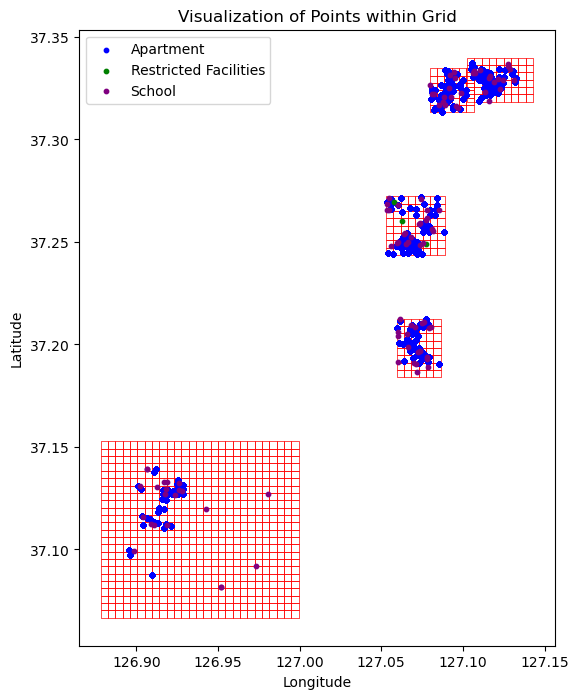

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))

# 그리드 데이터 시각화
grid_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=0.5, label='Grid')

# 각 데이터 레이어 시각화
apartment_in_grid.plot(ax=ax, color='blue', markersize=10, label='Apartment')
restricted_in_grid.plot(ax=ax, color='green', markersize=10, label='Restricted Facilities')
school_in_grid.plot(ax=ax, color='purple', markersize=10, label='School')

# 범례 추가 및 제목 설정
plt.legend()
plt.title('Visualization of Points within Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 지도 시각화
plt.show()

In [21]:
# 후보지(파란 점) 데이터 준비
candidates = grid_gdf.copy()  # 파란 점 (후보지)
demand_points = apartment_in_grid.copy()  # 수요지 (아파트)

# GeoDataFrame 확인 및 변환
if not isinstance(candidates, gpd.GeoDataFrame):
    candidates = gpd.GeoDataFrame(candidates, geometry=gpd.points_from_xy(candidates.longitude, candidates.latitude), crs="EPSG:4326")

if not isinstance(demand_points, gpd.GeoDataFrame):
    demand_points = gpd.GeoDataFrame(demand_points, geometry=gpd.points_from_xy(demand_points.longitude, demand_points.latitude), crs="EPSG:4326")

# Ensure that both candidates and demand_points geometries are Point objects
candidates.geometry = candidates.geometry.centroid  # Polygon을 Point로 변환 (중심점)
demand_points.geometry = demand_points.geometry.centroid  # 동일하게 Point로 변환

# 거리 계산 함수
def calculate_distance(point1, point2):
    return np.sqrt((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2)

# 거리 행렬 계산 (후보지와 수요지 사이)
distance_matrix = np.zeros((len(candidates), len(demand_points)))
for i, candidate in enumerate(candidates.geometry):
    for j, demand_point in enumerate(demand_points.geometry):
        distance_matrix[i, j] = calculate_distance(candidate, demand_point)

# 최적화 함수 실행
def optimize_vertiports(k):
    # 문제 정의
    problem = LpProblem("Vertiport_Location_Optimization", LpMinimize)

    # 변수 정의
    x = LpVariable.dicts("x", [(i, j) for i in range(len(candidates)) for j in range(len(demand_points))], 0, 1, LpBinary)
    y = LpVariable.dicts("y", range(len(candidates)), 0, 1, LpBinary)

    # 목적 함수: 거리 최소화
    problem += lpSum(distance_matrix[i][j] * x[i, j] for i in range(len(candidates)) for j in range(len(demand_points)))

    # 제약 조건 1: 버티포트 개수는 k개
    problem += lpSum(y[i] for i in range(len(candidates))) == k


    # 제약 조건 2: 수요지가 버티포트에 할당될 때만 고려
    for j in range(len(demand_points)):
        problem += lpSum(x[i, j] for i in range(len(candidates))) == 1  # 모든 수요지 할당

    # 제약 조건 3: 버티포트 간 최소 거리 조건
    for i in range(len(candidates)):
        for i_prime in range(i + 1, len(candidates)):
            distance = calculate_distance(candidates.geometry.iloc[i], candidates.geometry.iloc[i_prime])
            problem += lpSum([y[i], y[i_prime]]) * distance >= 20


    # 제약 조건 4: 후보지 제외 조건 (산지, 하천, 자연환경보전지역 등)
    for i in range(len(candidates)):
        if "land_use" in candidates.columns and candidates.iloc[i]["land_use"] in ["forest", "river", "protected"]:
            problem += y[i] == 0

    
    # 제약 조건 5: 기타 시설 및 학교와의 거리 조건
    for i in range(len(candidates)):
        if "geometry" in restricted_in_grid:
            for restricted in restricted_in_grid.geometry:
                distance = calculate_distance(candidates.geometry.iloc[i], restricted)
                # 버티포트 i가 선택되고 거리가 1 미만이면 문제가 발생
                problem += lpSum(y[i]) * (distance + 1)  # 이 거리 조건이 충족되지 않으면 모델이 해를 찾지 못함

        if "geometry" in school_in_grid:
            for school in school_in_grid.geometry:
                distance = calculate_distance(candidates.geometry.iloc[i], school)
                # 버티포트 i가 선택되고 거리가 2 미만이면 문제가 발생
                problem += lpSum(y[i]) * (distance + 2)  # 이 거리 조건이 충족되지 않으면 모델이 해를 찾지 못함

    # 문제 풀기
    problem.solve()

    # 결과 출력
    vertiports = [i for i in range(len(candidates)) if y[i].varValue > 0.5]
    return vertiports

# 각 k 값에 대해 최적화 수행
results = {}
for k in range(2, 13):
    results[k] = optimize_vertiports(k)

# 결과 확인
results

/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/638634230.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  candidates.geometry = candidates.geometry.centroid  # Polygon을 Point로 변환 (중심점)
/var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/ipykernel_81002/638634230.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  demand_points.geometry = demand_points.geometry.centroid  # 동일하게 Point로 변환
/opt/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1650: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/6d258ce46cba492a8f50d3332259a594-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/j4/2041ftmn23q6ckn4xskb5z9c0000gn/T/6d258ce46cba492a8f50d3332259a594-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 378444 COLUMNS
At line 46015796 RHS
At line 46394236 BOUNDS
At line 61366137 ENDATA
Problem MODEL has 378439 rows, 14971900 columns and 15693550 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 179.90 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       199.21   (Wallclock seconds):       203.78

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.